In [1]:
%pylab inline
import tensorflow as tf
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

# You may need to adapt this path depending on where you are running the notebook
# This is the power spectrum of initial conditions
klin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# So, now we need to devise a scheme to export lens planes
# as the simulation runs... We can begin by computing the
# scale factors that correspond to fixed width in radial comoving 
# distance
import jax_cosmo as jc
cosmo = jc.Planck15()

In [3]:
200./jc.background.transverse_comoving_distance(cosmo, 
                                             jc.utils.z2a(0.8))*180/pi

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:6188: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


DeviceArray([5.89388], dtype=float32)

In [4]:
# ok, so we want let's say lens planes of size 200 Mpc/h
r = np.linspace(0, 2000,10, endpoint=True)
a = jc.background.a_of_chi(cosmo, r)

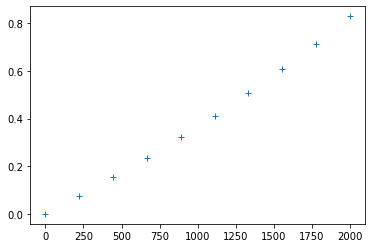

In [5]:
# This allows us to go to roughly z=1
plot(r,jc.utils.a2z(a), '+')

In [6]:
import flowpm
# We will first run the simulation to the lowest scaler factor entering the lightcone
init_stages = np.linspace(0.1, a[-1], 4, endpoint=True)
initial_conditions = flowpm.linear_field([64,64,640],    # size of the cube
                                         [200,200,2000], # Physical size of the cube
                                         ipklin,         # Initial powerspectrum
                                         batch_size=1)
# Sample particles
state = flowpm.lpt_init(initial_conditions, a0=0.1)   
# Evolve particles down to z=0
med_state = flowpm.nbody(state, init_stages, [64,64,640])         
# Retrieve final density field
med_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), med_state[0])

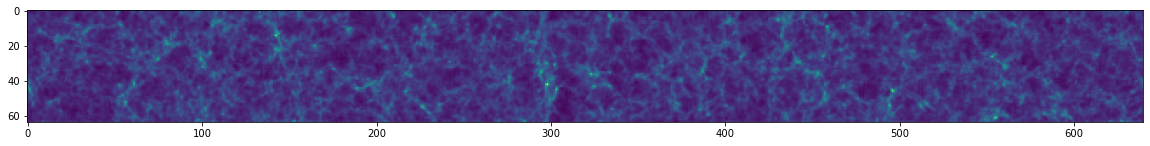

In [7]:
# At this stage we are at the right edge of the lightcone
figure(figsize=[20,5])
imshow(tf.reshape(med_field, [64,64,640]).numpy().sum(axis=0))

In [8]:
# Sweet, now we can run the lightcone, we assume that the timesteps are equally spaced
# in radial comoving distance

In [55]:
from flowpm.tfpm import kick, drift, force
from astropy.cosmology import Planck15


def lightcone(state, stages, nc,
              plane_resolution, # in arcmin
              plane_size, # in pixels
              cosmology=Planck15, pm_nc_factor=1, 
              name="NBody"):
  """
  Integrate the evolution of the state across the givent stages

  Parameters:
  -----------
  state: tensor (3, batch_size, npart, 3)
    Input state

  stages: array
    Array of scale factors, also define slices in the volume

  nc: int
    Number of cells

  pm_nc_factor: int
    Upsampling factor for computing

  Returns
  -------
  state: tensor (3, batch_size, npart, 3)
    Integrated state to final condition
  """
  with tf.name_scope(name):
    state = tf.convert_to_tensor(state, name="state")

    shape = state.get_shape()
    batch_size = shape[1]

    # Unrolling leapfrog integration to make tf Autograph happy
    if len(stages) == 0:
      return state

    ai = stages[0]

    # first force calculation for jump starting
    state = force(state, nc, pm_nc_factor=pm_nc_factor, cosmology=cosmology)

    # Compute the width of the lens planes based on number of time steps
    w = nc[2]//(len(stages)-1)
    nx = nc[0]
    nz = nc[2]
    
    lps = []
    lps_a = []
    
    x, p, f = ai, ai, ai
    # Loop through the stages
    for i in range(len(stages) - 1):
        a0 = stages[i]
        a1 = stages[i + 1]
        ah = (a0 * a1) ** 0.5

        # Kick step
        state = kick(state, p, f, ah, cosmology=cosmology)
        p = ah

        # Drift step
        state = drift(state, x, p, a1, cosmology=cosmology)
        x = a1

        # Access the positions of the particles
        pos = state[0]
        d = pos[:,:,2]
        
        # This is the transverse comoving distance inside the box
        xy = pos[:,:,:2] - nx/2
        
        # Compute density plane in sky coordinates around the center of the lightcone
        # TODO: Confirm conversion from comoving distances to angular size! I thought
        # we should be using the angular diameter distance, but as far as I can see
        # everyone uses the transverse comoving distance, and I don't understand exactly why
        lens_plane = tf.zeros([batch_size, plane_size, plane_size])
        
        # Convert coordinates to angular coords, and then into plane coords
        xy = (xy / tf.expand_dims(d,-1))/np.pi*180*60/plane_resolution
        xy = xy + plane_size/2
        
        # Selecting only the particles contributing to the lens plane
        mask = tf.where((d>(nz - (i+1)*w)) & (d <= (nz - i*w)),1.,0.)
        # And falling inside the plane, NOTE: This is only necessary on CPU, on GPU
        # cic paint 2d can be made to work with non periodic conditions.
        mask = mask * tf.where((xy[...,0]>0) & (xy[...,0]<plane_size),1.,0.)
        mask = mask * tf.where((xy[...,1]>0) & (xy[...,1]<plane_size),1.,0.)
        
        # Compute lens planes by projecting particles
        lens_plane = flowpm.utils.cic_paint_2d(lens_plane, xy + plane_size/2 ,mask)
        lps.append(lens_plane)
        lps_a.append(ah)
        
        # Here we could trim the state vector for particles originally beyond the current lens plane
        # This way the simulation becomes smaller as it runs and we save resources
        state = tf.reshape(state, [3,batch_size, nc[0], nc[1],-1, 3])
        state = state[:,:,:,:,:(nz - i*w - w // 2),:] # We keep w/2 to be safe, so we allow particle to travel
                                                     # A max distance of width/2
        # redefine shape of state
        nc = state.get_shape()[2:5]
        state = tf.reshape(state, [3,batch_size,-1,3])
        # So this seems to work, but we should be a tiny bit careful because we break periodicity in the z
        # direction at z=0.... probably not a big deal but still gotta check what that does.
        
        
        # Force
        state = force(state, nc, pm_nc_factor=pm_nc_factor, cosmology=cosmology)
        f = a1

        # Kick again
        state = kick(state, p, f, a1, cosmology=cosmology)
        p = a1

    return state, lps_a, lps

In [56]:
5.*60/64 # What pixel resolution do we need to cover the 5 tansverse degrees with 128 pixel images

4.6875

In [57]:
final_state, lps_a, lps = lightcone(med_state, a[::-1], 
                                    [64, 64, 640], 
                                    5.*60/64, 64)  

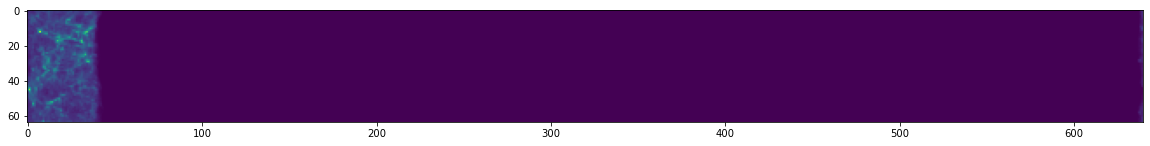

In [63]:
# Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

# And this is what remains of the simulation at redhift=0 
figure(figsize=[20,5])
imshow(tf.reshape(final_field, [64,64,-1]).numpy().sum(axis=0))

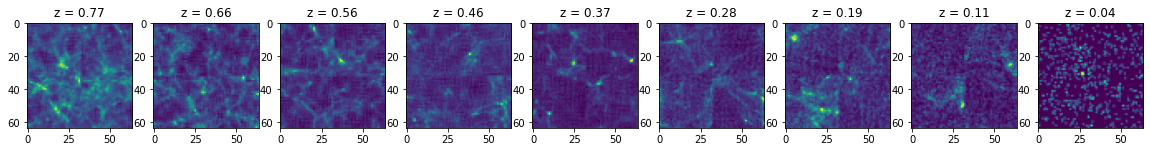

In [58]:
# Here are the lens planes exported during the simulation
figure(figsize=(20,5))
for i in range(9):
    subplot(1,9,i+1)
    imshow(lps[i][0]);
    title('z = %0.2f'%jc.utils.a2z(lps_a[i]))

In [ ]:
# Cool :-D last thing to do is to stack them according to the lensing efficiency and we would get 
# actual convergence maps \o/

In [37]:
final_state.shape

TensorShape([3, 1, 2621440, 3])

In [39]:
2621440/64/64

640.0